## PylipID


In [6]:
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from pylipid.api import LipidInteraction

# Function for natural sorting
def natural_sort_key(filename):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', filename)]

# Get all DCD files in sorted order
trajfile_list = sorted(glob.glob("step7.*_production.dcd"), key=natural_sort_key)
topfile_list = "step5_input.psf"

trajfile_list


['step7.1_production.dcd',
 'step7.2_production.dcd',
 'step7.3_production.dcd',
 'step7.4_production.dcd',
 'step7.5_production.dcd',
 'step7.6_production.dcd',
 'step7.7_production.dcd',
 'step7.8_production.dcd',
 'step7.9_production.dcd',
 'step7.10_production.dcd',
 'step7.11_production.dcd',
 'step7.12_production.dcd',
 'step7.13_production.dcd',
 'step7.14_production.dcd',
 'step7.15_production.dcd',
 'step7.16_production.dcd',
 'step7.17_production.dcd',
 'step7.18_production.dcd',
 'step7.19_production.dcd',
 'step7.20_production.dcd',
 'step7.21_production.dcd',
 'step7.22_production.dcd',
 'step7.23_production.dcd',
 'step7.24_production.dcd',
 'step7.25_production.dcd']

In [5]:
import MDAnalysis as mda
u = mda.Universe(topfile_list, "step7.1_production.dcd")
print("Number of atoms:", u.atoms.n_atoms)
print("Number of frames:", len(u.trajectory))
print("Timestep between frames:", u.trajectory.dt)


Number of atoms: 178044
Number of frames: 100
Timestep between frames: 100.00000029814058


c:\Users\lyj12\anaconda3\envs\MD\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## Dual Cutoffs

## Lipid Interaction

In [6]:


lipid_interaction = LipidInteraction(
    trajfile_list=trajfile_list,
    topfile_list=topfile_list,
    lipid='POPC',
    cutoffs=[0.25, 0.55],
    nprot=2,        # Number of protein copies in the system.
    timeunit="ns", 
    dt_traj=100.0   # Timestep of trajectories. 
)

# Collect residue contacts with the lipid
lipid_interaction.collect_residue_contacts()



COLLECT INTERACTIONS FROM TRAJECTORIES: 100%|██████████| 25/25 [13:12:02<00:00, 1900.91s/it]  


save data

In [ ]:
# import pickle

# # Save the lipid_interaction object
# with open("pylipid/lipid_interaction0.25_0.55.pkl", "wb") as f:
#     pickle.dump(lipid_interaction, f)

## Load Data

In [7]:
import pickle
with open("pylipid/lipid_interaction0.25_0.55.pkl", "rb") as f:
    lipid_interaction = pickle.load(f)


## Contact Analysis

In [8]:
corr_matrix = lipid_interaction.interaction_corrcoef
np.savetxt("pylipid/interaction_correlation_matrix.csv", corr_matrix, delimiter=",")
print("Interaction correlation matrix saved to 'interaction_correlation_matrix.csv'")

Interaction correlation matrix saved to 'interaction_correlation_matrix.csv'


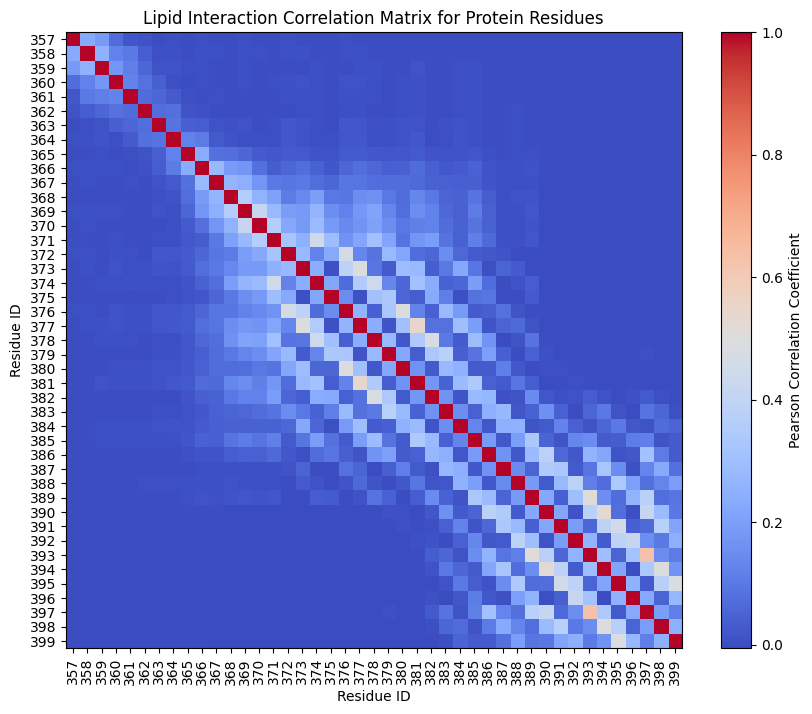

In [9]:
num_residues = len(corr_matrix)
residue_indices = np.arange(357, 357 + num_residues)  # Adjust to start from residue ID 357

# Plot the correlation matrix as a heatmap with adjusted residue indices
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Pearson Correlation Coefficient")
plt.title("Lipid Interaction Correlation Matrix for Protein Residues")

# Set the x and y ticks to correspond to the residue indices
plt.xticks(ticks=np.arange(num_residues), labels=residue_indices, rotation=90)
plt.yticks(ticks=np.arange(num_residues), labels=residue_indices)

plt.xlabel("Residue ID")
plt.ylabel("Residue ID")
plt.show()

### Occupancy

In [10]:
# Calculate lipid occupancy for all residues (default)
all_residue_occupancies = lipid_interaction.compute_residue_occupancy()

import pandas as pd

# Create a DataFrame for occupancy
occupancy_df = pd.DataFrame({
    "Residue ID": range(357,357+len(all_residue_occupancies)),
    "Lipid Occupancy (%)": all_residue_occupancies
})
occupancy_df.to_csv("pylipid/residue_occupancy.csv", index=False)
print("Residue occupancy data saved to 'pylipid/residue_occupancy.csv'")


CALCULATE OCCUPANCY: 100%|██████████| 43/43 [00:00<00:00, 677.10it/s]

Residue occupancy data saved to 'pylipid/residue_occupancy.csv'


    Residue ID  Mean Occupancy (%)  Max Occupancy (%)  Min Occupancy (%)
0          357            5.413192          76.015474           0.000000
1          358            3.430399          54.352031           0.000000
2          359            2.761283          45.454545           0.000000
3          360            2.194456          15.600000           0.000000
4          361            2.246615          28.626692           0.000000
5          362            1.856610          20.000000           0.000000
6          363            2.762193          17.000000           0.000000
7          364            4.931581         100.000000           0.000000
8          365            8.955367         100.000000           0.000000
9          366           15.134069          66.000000           0.000000
10         367           30.135104         100.000000           0.000000
11         368           51.604564         100.000000          14.000000
12         369           58.308691         100.0000

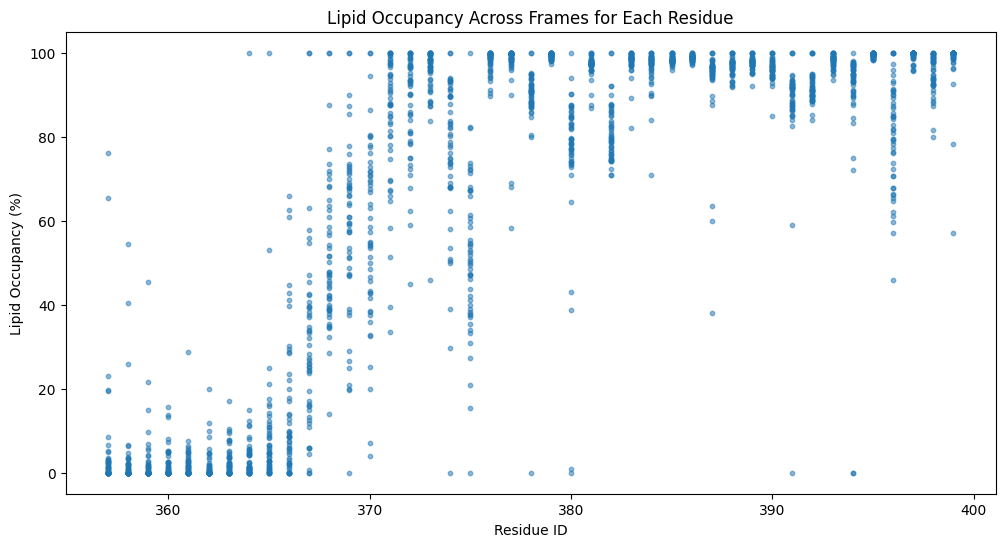

In [11]:
import pandas as pd
import numpy as np

# # Load the CSV file
occupancy_df = pd.read_csv("pylipid/residue_occupancy.csv")

# Convert the occupancy column from strings to lists
occupancy_df["Lipid Occupancy (%)"] = occupancy_df["Lipid Occupancy (%)"].apply(eval)

# Calculate the mean occupancy for each residue
occupancy_df["Mean Occupancy (%)"] = occupancy_df["Lipid Occupancy (%)"].apply(np.mean)
occupancy_df["Max Occupancy (%)"] = occupancy_df["Lipid Occupancy (%)"].apply(np.max)
occupancy_df["Min Occupancy (%)"] = occupancy_df["Lipid Occupancy (%)"].apply(np.min)

# Display the resulting DataFrame with summary statistics
print(occupancy_df[["Residue ID", "Mean Occupancy (%)", "Max Occupancy (%)", "Min Occupancy (%)"]])

import matplotlib.pyplot as plt

# Flatten the data for visualization
flat_data = pd.DataFrame({
    "Residue ID": np.repeat(occupancy_df["Residue ID"].values, occupancy_df["Lipid Occupancy (%)"].str.len()),
    "Occupancy (%)": np.concatenate(occupancy_df["Lipid Occupancy (%)"].values)
})

# Plot the flattened data
plt.figure(figsize=(12, 6))
plt.scatter(flat_data["Residue ID"], flat_data["Occupancy (%)"], alpha=0.5, s=10)
plt.xlabel("Residue ID")
plt.ylabel("Lipid Occupancy (%)")
plt.title("Lipid Occupancy Across Frames for Each Residue")
plt.show()


### Residue durations

In [12]:
# Calculate contact durations for all residues
all_residue_durations = lipid_interaction.compute_residue_duration()
import csv
# Print the first few residues' durations as an example
for i, durations in enumerate(all_residue_durations[:5]):
    print(f"Residue {i}: Durations (in frames) = {durations}")

# Save durations to a CSV file
# with open("pylipid/residue_durations.csv", mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Residue ID", "Durations (in frames)"])

#     for i, durations in enumerate(all_residue_durations):
#         writer.writerow([i, durations])



CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]

Residue 0: Durations (in frames) = [[200.0], [0], [100.0, 200.0, 200.0, 300.0, 300.0, 700.0, 1200.0], [100.0, 200.0, 200.0, 200.0, 300.0, 400.0, 400.0, 900.0], [200.0, 300.0, 300.0], [100.0, 200.0, 200.0, 200.0, 300.0, 300.0, 300.0, 400.0, 600.0, 600.0, 600.0, 700.0, 1100.0, 1500.0, 2600.0], [0], [0], [0], [0], [200.0, 200.0, 400.0, 600.0], [0], [100.0, 100.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 300.0, 400.0, 400.0, 500.0, 500.0, 600.0, 700.0, 800.0], [200.0, 1200.0], [200.0, 200.0, 200.0, 300.0, 400.0], [100.0, 200.0, 400.0, 500.0, 600.0, 600.0, 600.0, 600.0, 700.0, 800.0, 900.0, 1100.0, 1400.0, 1500.0, 1600.0, 1700.0, 2100.0, 3000.0, 3500.0, 5000.0], [100.0, 200.0, 400.0, 900.0], [200.0, 200.0, 600.0, 3100.0], [100.0, 200.0, 300.0, 300.0, 400.0, 500.0, 500.0, 500.0, 500.0, 600.0, 1600.0, 1800.0, 2000.0, 6400.0, 9100.0], [100.0, 100.0, 200.0, 200.0, 300.0, 600.0, 700.0], [0], [100.0, 100.0, 100.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 300.0, 500.0, 600.0

### Lipid Count

In [13]:
# Calculate the lipid counts for all residues
all_residue_lipidcounts = lipid_interaction.compute_residue_lipidcount()

# Print sample lipid counts for the first few residues
for i, lipidcount in enumerate(all_residue_lipidcounts[:5]):
    print(f"Residue {i}: Lipid count = {lipidcount}")

# Convert the lipid counts into a DataFrame for easier analysis
import pandas as pd
import numpy as np

lipidcount_df = pd.DataFrame({
    "Residue ID": range(len(all_residue_lipidcounts)),
    "Lipid Count": all_residue_lipidcounts
})

# Ensure the output directory exists
import os
os.makedirs("pylipid", exist_ok=True)

# Save lipid count data to CSV
# lipidcount_df.to_csv("pylipid/residue_lipidcount.csv", index=False)
# print("Lipid count data saved to 'pylipid/residue_lipidcount.csv'")


CALCULATE RESIDUE LIPIDCOUNT:   0%|          | 0/43 [00:00<?, ?it/s]

CALCULATE RESIDUE LIPIDCOUNT: 100%|██████████| 43/43 [00:00<00:00, 498.83it/s]

Residue 0: Lipid count = [1.0, 0, 1.2857142857142858, 1.0, 1.25, 1.3333333333333333, 0, 0, 0, 0, 1.2, 0, 1.0384615384615385, 1.0, 1.0, 1.4489795918367347, 1.1428571428571428, 1.0, 1.5463917525773196, 1.0, 0, 1.0303030303030303, 0, 1.0, 1.3333333333333333, 0, 0, 0, 1.3636363636363635, 1.0, 0, 0, 1.0, 1.0, 2.0814249363867683, 1.0, 2.7522935779816513, 1.0, 1.1428571428571428, 1.125, 1.1428571428571428, 1.0, 1.0, 1.0666666666666667, 1.0, 1.0833333333333333, 1.1428571428571428, 2.382608695652174, 0, 0]
Residue 1: Lipid count = [0, 0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 0, 0, 1.0, 1.0, 1.0, 1.4031007751937985, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 1.0, 1.0, 1.3772241992882561, 1.0, 1.49009900990099, 0, 1.1666666666666667, 0, 1.0, 1.0, 0, 1.3125, 1.125, 1.0, 1.0, 1.125, 0, 0]
Residue 2: Lipid count = [0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.5, 0, 1.2, 0, 1.0, 1.0, 1.0, 1.0588235294117647, 1.0833333333333333, 1.0, 1.0344827586206897, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 0, 1.1111111111111

    Residue ID  Mean Lipid Count  Max Lipid Count  Min Lipid Count
0            0          0.857858         2.752294         0.000000
1            1          0.599992         1.490099         0.000000
2            2          0.556045         1.500000         0.000000
3            3          0.658114         1.173913         0.000000
4            4          0.728450         1.250000         0.000000
5            5          0.614817         1.437500         0.000000
6            6          0.783784         1.285714         0.000000
7            7          0.843537         1.434783         0.000000
8            8          0.942422         1.272727         0.000000
9            9          0.927239         1.294118         0.000000
10          10          1.055407         2.000000         0.000000
11          11          1.195371         1.571429         1.000000
12          12          1.228347         1.639908         0.000000
13          13          1.265679         3.000000         1.00

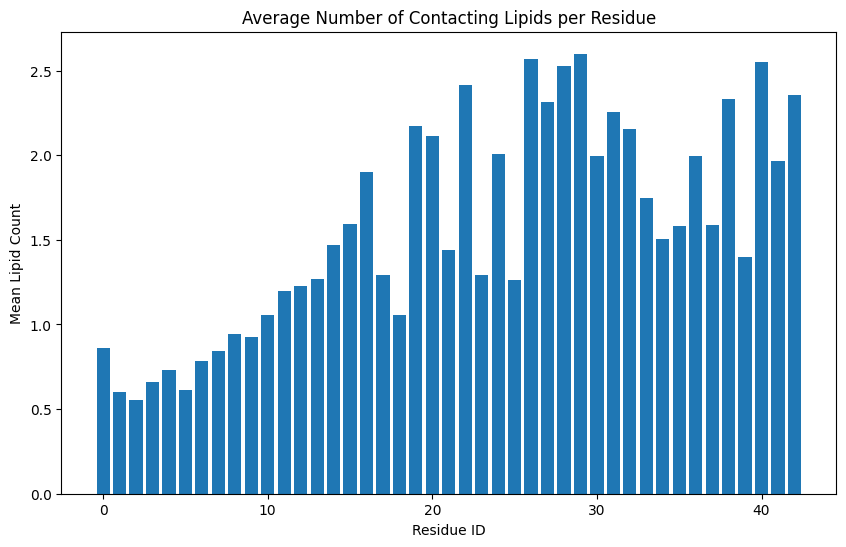

In [14]:
# Calculate the mean lipid count for each residue
lipidcount_df["Mean Lipid Count"] = lipidcount_df["Lipid Count"].apply(np.mean)
lipidcount_df["Max Lipid Count"] = lipidcount_df["Lipid Count"].apply(np.max)
lipidcount_df["Min Lipid Count"] = lipidcount_df["Lipid Count"].apply(np.min)

# Display the resulting DataFrame with summary statistics
print(lipidcount_df[["Residue ID", "Mean Lipid Count", "Max Lipid Count", "Min Lipid Count"]])

# Plot mean lipid count for each residue
plt.figure(figsize=(10, 6))
plt.bar(lipidcount_df["Residue ID"], lipidcount_df["Mean Lipid Count"])
plt.xlabel("Residue ID")
plt.ylabel("Mean Lipid Count")
plt.title("Average Number of Contacting Lipids per Residue")
plt.show()

### residue k-off

In [15]:
residue_koff=lipid_interaction.compute_residue_koff(
    residue_id=None,               # All residues
    nbootstrap=10,                 # Number of bootstraps
    initial_guess=[1.0, 1.0, 1.0, 1.0],
    save_dir="pylipid",    # Save results to this directory
    plot_data=True,                # Generate plots
    fig_close=True,                # Close plots after saving
    fig_format='pdf',              # Save as PDF
    num_cpus=4                     # Use 4 CPUs
)

residue_koff

c:\Users\lyj12\anaconda3\envs\MD\Lib\site-packages\pylipid\api\api.py:685: UserWarning: Trajectories have different lengths. This will impair the accuracy of koff calculation!
  warnings.warn(
CALCULATE KOFF FOR RESIDUES: 100%|██████████| 43/43 [00:09<00:00,  4.74it/s]


([1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

### binding sites

In [31]:
# Calculate binding sites with a specified threshold
binding_sites = lipid_interaction.compute_binding_nodes(threshold=4, print_data=True)


Network modularity: 0.541
#########################
Binding Site ID: 0
   Residue -- Residue ID  
    357LEU -- 0           
    358PRO -- 1           
    359ALA -- 2           
    360GLU -- 3           
    361GLU -- 4           
#########################
#########################
Binding Site ID: 1
   Residue -- Residue ID  
    365GLU -- 8           
    366ALA -- 9           
    367ASP -- 10          
    368GLU -- 11          
    369ALA -- 12          
    370GLY -- 13          
#########################
#########################
Binding Site ID: 2
   Residue -- Residue ID  
    371SER -- 14          
    374ALA -- 17          
    375GLY -- 18          
    378SER -- 21          
    379TYR -- 22          
    382GLY -- 25          
    385LEU -- 28          
#########################
#########################
Binding Site ID: 3
   Residue -- Residue ID  
    372VAL -- 15          
    373TYR -- 16          
    376ILE -- 19          
    377LEU -- 20          
    380GLY -- 

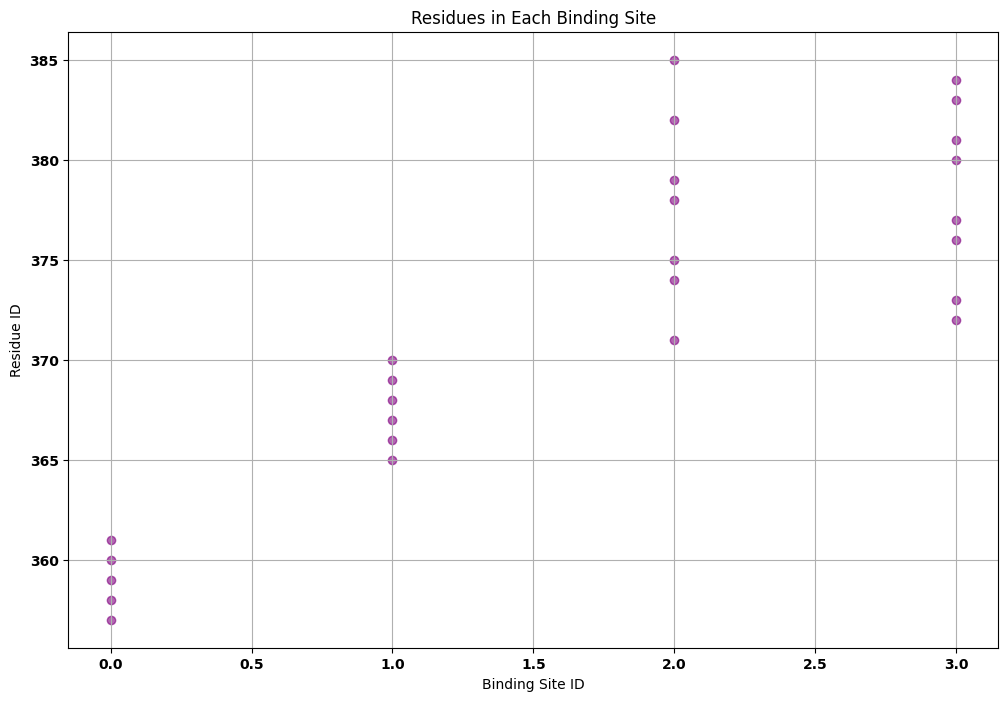

In [32]:
binding_sites = list(binding_sites)

binding_sites[0] = [[residue + 357 for residue in sublist] for sublist in binding_sites[0]]

residues = []
site_ids = []
for site_id, residue_list in enumerate(binding_sites[0]):
    residues.extend(residue_list)
    site_ids.extend([site_id] * len(residue_list))

# Scatter plot showing each residue in each binding site
plt.figure(figsize=(12, 8))
plt.scatter(site_ids, residues, alpha=0.6, color='purple')
plt.xlabel("Binding Site ID")
plt.ylabel("Residue ID")
plt.title("Residues in Each Binding Site")
plt.grid(True)
plt.show()

In [33]:
from pylipid.func import get_node_list

get_node_list(corr_matrix, threshold=4)

([[0, 1, 2, 3, 4, 5],
  [6, 7, 8, 9, 10],
  [11, 12, 13, 14, 17, 18, 21, 22, 25],
  [15, 16, 19, 20, 23, 24, 26, 27]],
 0.536753831667856)

### site duration

In [34]:
site_duration=lipid_interaction.compute_site_duration()
site_duration

CALCULATE DURATION PER BINDING SITE: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


[[[200.0],
  [100.0, 100.0, 100.0, 300.0, 400.0, 400.0, 800.0],
  [100.0,
   200.0,
   200.0,
   200.0,
   200.0,
   300.0,
   300.0,
   300.0,
   600.0,
   700.0,
   700.0,
   1000.0,
   1200.0,
   1900.0],
  [100.0,
   200.0,
   200.0,
   200.0,
   200.0,
   300.0,
   300.0,
   300.0,
   300.0,
   400.0,
   400.0,
   400.0,
   600.0,
   800.0,
   900.0,
   900.0,
   1000.0,
   1200.0,
   3000.0],
  [100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   200.0,
   300.0,
   300.0,
   300.0,
   400.0,
   500.0,
   500.0,
   500.0,
   600.0,
   600.0,
   600.0,
   700.0,
   800.0,
   800.0,
   800.0,
   800.0,
   900.0,
   1000.0,
   1000.0,
   1700.0,
   1800.0,
   2200.0],
  [100.0,
   200.0,
   200.0,
   200.0,
   200.0,
   200.0,
   200.0,
   200.0,
   300.0,
   300.0,
   300.0,
   300.0,
   300.0,
   300.0,
   400.0,
   400.0,
   400.0,
   500.0,
   500.0,
   600.0,
   600.0,
   600.0,
   600.0,
   700.0,
   1100.0,
   1500.0,
   3100.0,
   3400.0],
  [0],
  [0],
  [300.0, 300.0, 400.0,

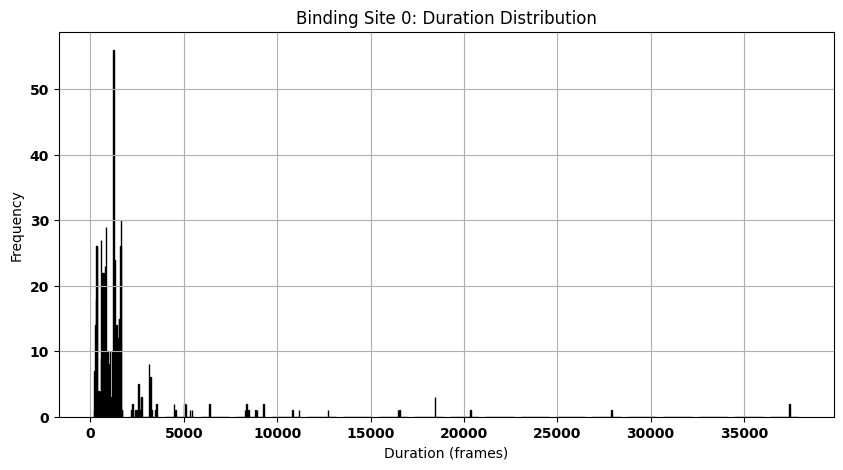

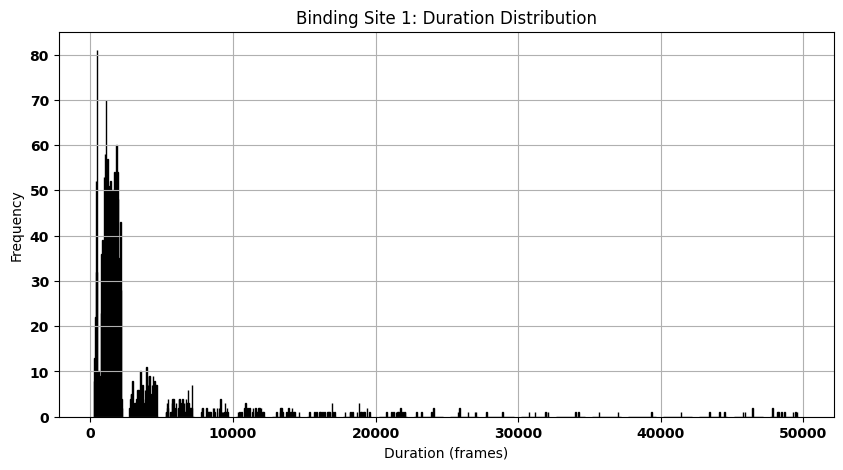

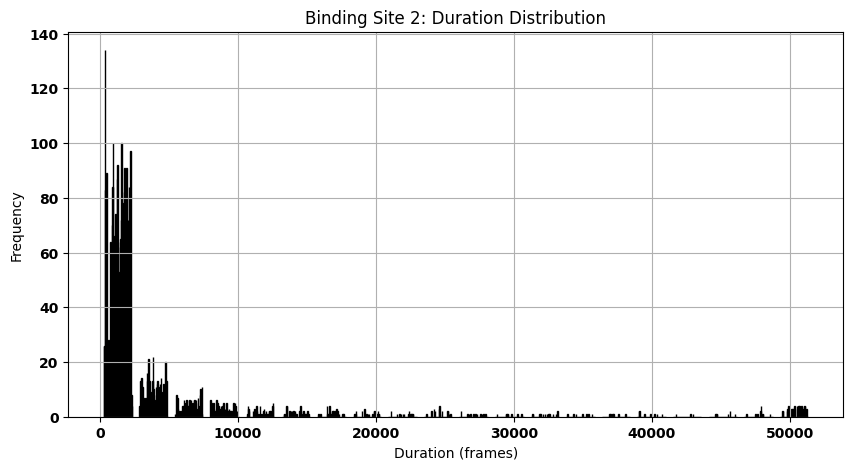

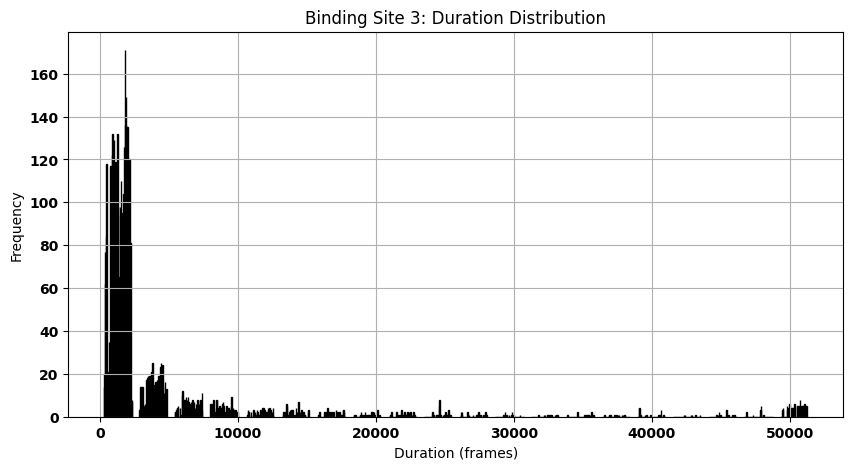

In [35]:
import matplotlib.pyplot as plt

for site_id, durations in enumerate(site_duration):
    plt.figure(figsize=(10, 5))
    plt.hist(durations, bins=20, edgecolor='black')
    plt.title(f"Binding Site {site_id}: Duration Distribution")
    plt.xlabel("Duration (frames)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


### Site occupancy

In [36]:
# Calculate occupancy for all binding sites


site_occupancy = lipid_interaction.compute_site_occupancy(binding_site_id=None)

occupancy_data = {
    "Binding Site ID": [],
    "Occupancy (%)": []
}

# Iterate over each binding site and its occupancies
for site_id, occupancies in enumerate(site_occupancy):
    occupancy_data["Binding Site ID"].append(site_id)
    occupancy_data["Occupancy (%)"].append(occupancies)

# Create DataFrame from occupancy data
site_occupancy_df = pd.DataFrame(occupancy_data)

# site_occupancy_df.to_csv("pylipid/site_occupancy.csv", index=False)
site_occupancy_df

CALCULATE OCCUPANCY PER BINDING SITE: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


,Binding Site ID,Occupancy (%)
0,0,"[1.0, 10.0, 7.0, 9.25, 12.195121951219512, 14...."
1,1,"[48.0, 99.0, 86.25, 81.0, 98.3739837398374, 66..."
2,2,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
3,3,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."


Text(0.5, 1.0, 'Lipid Occupancy for Each Binding Site')

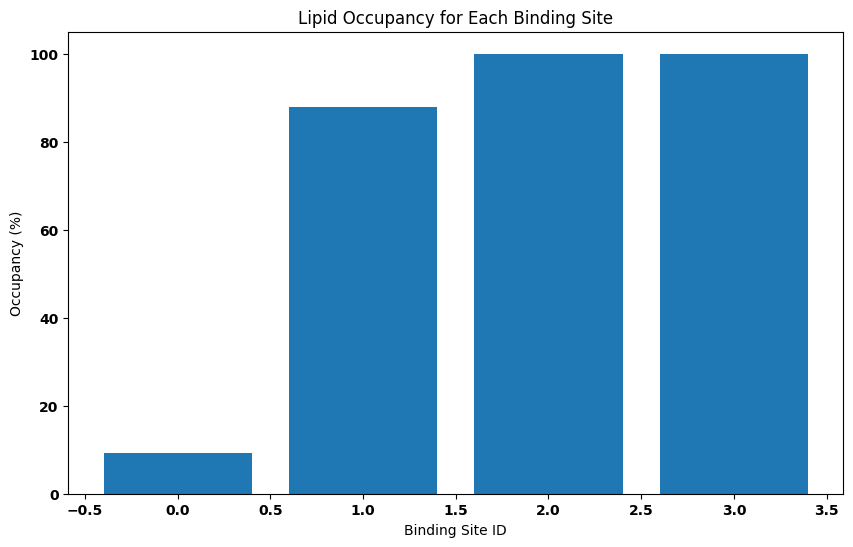

In [37]:
# Calculate the mean occupancy per binding site if it's a list of lists
average_occupancy = [sum(occupancies) / len(occupancies) for occupancies in site_occupancy]

# Plot and save
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_occupancy)), [o for o in average_occupancy])  # Convert to percentage
plt.xlabel("Binding Site ID")
plt.ylabel("Occupancy (%)")
plt.title("Lipid Occupancy for Each Binding Site")


### site lipid count

In [38]:
site_li_count=lipid_interaction.compute_site_lipidcount()
site_li_count

site_li_count_df = pd.DataFrame(
    {"Binding Site ID": list(range(len(site_li_count))), "Lipid Count": site_li_count}
)

# site_li_count_df.to_csv("pylipid/site_lipid_count.csv", index_label=False)

CALCULATE LIPIDCOUNT PER BINDING SITE: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


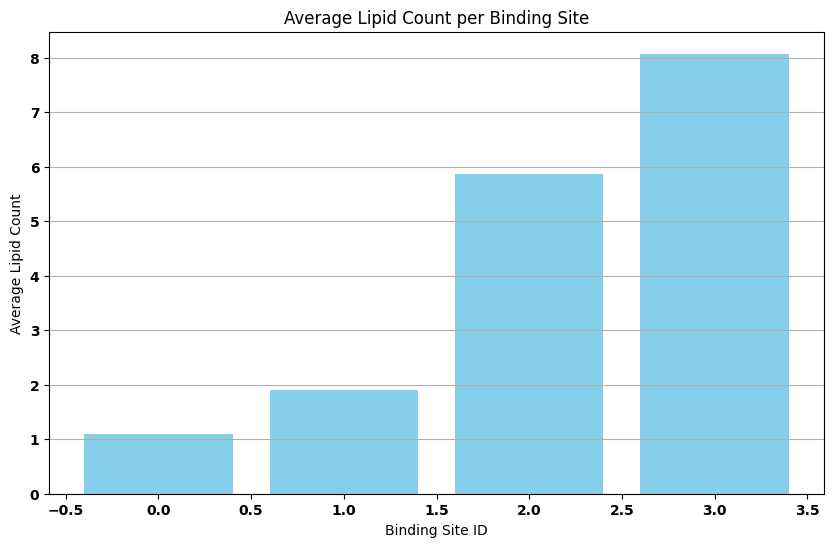

In [39]:
site_li_count_data = {
    "Binding Site ID": [],
    "Average Lipid Count": []
}

for site_id, lipid_counts in enumerate(site_li_count):
    site_li_count_data["Binding Site ID"].append(site_id)
    # Average lipid count for each binding site
    average_count = sum(lipid_counts) / len(lipid_counts) if len(lipid_counts) > 0 else 0
    site_li_count_data["Average Lipid Count"].append(average_count)

plt.figure(figsize=(10, 6))
plt.bar(site_li_count_data["Binding Site ID"], site_li_count_data["Average Lipid Count"], color="skyblue")
plt.xlabel("Binding Site ID")
plt.ylabel("Average Lipid Count")
plt.title("Average Lipid Count per Binding Site")
plt.grid(axis="y")
plt.show()

### Site k-off

In [40]:
site_koff = lipid_interaction.compute_site_koff(
    binding_site_id=None,         # Analyze all binding sites
    nbootstrap=10,                # Perform 10 bootstrap iterations
    initial_guess=[1.0, 1.0, 1.0, 1.0],  # Initial guesses for fitting
    save_dir="pylipid",   # Save results to this directory
    plot_data=True,               # Generate plots
    fig_close=True,               # Close plots after saving
    fig_format="pdf",             # Save plots as PDF
    num_cpus=4                    # Use 4 CPUs
)

site_koff

c:\Users\lyj12\anaconda3\envs\MD\Lib\site-packages\pylipid\api\api.py:1131: UserWarning: Trajectories have different lengths. This will impair the accuracy of koff calculation!
  warnings.warn(


CALCULATE KOFF FOR BINDING SITES: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


([1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0])

In [49]:
koffs, res_times = lipid_interaction.compute_residue_koff(plot_data=True, fig_close=True)

c:\Users\lyj12\anaconda3\envs\MD\Lib\site-packages\pylipid\api\api.py:685: UserWarning: Trajectories have different lengths. This will impair the accuracy of koff calculation!
  warnings.warn(


Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\Interaction_POPC\Residue_koffs_POPC


CALCULATE KOFF FOR RESIDUES: 100%|██████████| 43/43 [00:12<00:00,  3.31it/s]


In [56]:
res_times


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## Overall Dataset

In [50]:
# Show statistics per trajectory, and save to log file
lipid_interaction.show_stats_per_traj(
    write_log=True,            # Save the log to a file
    print_log=True
)

print("Statistics per trajectory have been logged to 'trajectory_stats.log'")


###### Lipid: POPC
###### Lipid Atoms: None
###### Cutoffs: [0.25 0.55]
###### nprot: 2
###### Trajectories:
  step7.1_production.dcd
  step7.2_production.dcd
  step7.3_production.dcd
  step7.4_production.dcd
  step7.5_production.dcd
  step7.6_production.dcd
  step7.7_production.dcd
  step7.8_production.dcd
  step7.9_production.dcd
  step7.10_production.dcd
  step7.11_production.dcd
  step7.12_production.dcd
  step7.13_production.dcd
  step7.14_production.dcd
  step7.15_production.dcd
  step7.16_production.dcd
  step7.17_production.dcd
  step7.18_production.dcd
  step7.19_production.dcd
  step7.20_production.dcd
  step7.21_production.dcd
  step7.22_production.dcd
  step7.23_production.dcd
  step7.24_production.dcd
  step7.25_production.dcd
###### Coordinates:
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.psf
  step5_input.

In [58]:
interaction_data = lipid_interaction.dataset
interaction_data.to_csv("pylipid/1_dataset.csv", index=False)

print("Lipid interaction dataset saved to 'lipid_interaction_dataset.csv'")


with open("1.pkl", "wb") as f:
    pickle.dump(lipid_interaction, f)


interaction_data

Lipid interaction dataset saved to 'lipid_interaction_dataset.csv'


,Residue,Residue ID,Occupancy,Occupancy std,Duration,Duration std,Lipid Count,Lipid Count std,Koff,Residence Time,...,R Squared Bootstrap avg,Binding Site ID,Binding Site Duration,Binding Site Occupancy,Binding Site Lipid Count,Binding Site Koff,Binding Site Koff Bootstrap avg,Binding Site Residence Time,Binding Site R Squared,Binding Site R Squared Bootstrap avg
0,357LEU,0,5.413192,14.244878,1306.666667,3814.248974,0.857858,0.652551,1.0,1.0,...,-0.600851,0,1216.588419,9.166805,1.087857,1.0,1.0,1.0,-0.477322,-0.400178
1,358PRO,1,3.430399,9.846411,1271.304348,2847.050807,0.599992,0.542242,1.0,1.0,...,-0.261564,0,1216.588419,9.166805,1.087857,1.0,1.0,1.0,-0.477322,-0.400178
2,359ALA,2,2.761283,7.274326,915.909091,2017.023367,0.556045,0.541330,1.0,1.0,...,-0.115992,0,1216.588419,9.166805,1.087857,1.0,1.0,1.0,-0.477322,-0.400178
3,360GLU,3,2.194456,3.642928,639.378238,791.079558,0.658114,0.495215,1.0,1.0,...,0.227830,0,1216.588419,9.166805,1.087857,1.0,1.0,1.0,-0.477322,-0.400178
4,361GLU,4,2.246615,4.260393,648.571429,957.587672,0.728450,0.481101,1.0,1.0,...,0.159872,0,1216.588419,9.166805,1.087857,1.0,1.0,1.0,-0.477322,-0.400178
5,362GLU,5,1.856610,3.682485,507.731959,715.579219,0.614817,0.529602,1.0,1.0,...,0.240028,-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
6,363LEU,6,2.762193,3.528393,492.523364,502.895219,0.783784,0.469447,1.0,1.0,...,0.338927,-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
7,364VAL,7,4.931581,14.047086,600.772201,639.316254,0.843537,0.401755,1.0,1.0,...,0.258769,-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
8,365GLU,8,8.955367,15.723193,747.111111,888.896000,0.942422,0.320010,1.0,1.0,...,0.190362,1,2716.283266,87.800659,1.896733,1.0,1.0,1.0,-1.298749,-1.332409
9,366ALA,9,15.134069,17.155123,1287.940631,1763.867196,0.927239,0.348592,1.0,1.0,...,0.028773,1,2716.283266,87.800659,1.896733,1.0,1.0,1.0,-1.298749,-1.332409


CALCULATE LIPIDCOUNT PER BINDING SITE: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]


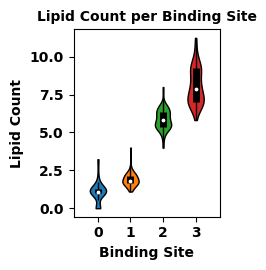

In [52]:
from pylipid.plot import plot_binding_site_data
import pandas as pd
import numpy as np

site_lipid_count = lipid_interaction.compute_site_lipidcount()
data = pd.DataFrame({
    f"Binding Site {idx}": counts for idx, counts in enumerate(site_lipid_count)
})

# Generate the violin plot
plot_binding_site_data(
    data=data,
    fig_fn="lipid_count_violin_plot.pdf",
    ylabel="Lipid Count",
    title="Lipid Count per Binding Site",
    fig_close=False
)

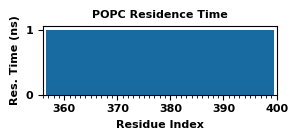

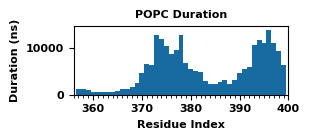

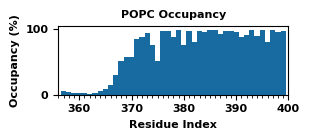

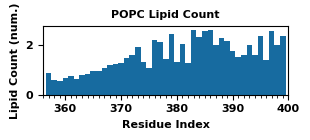

In [ ]:
for item in ["Residence Time", "Duration", "Occupancy", "Lipid Count"]:
    lipid_interaction.plot(item=item, save_dir='pylipid')

In [54]:
lipid_interaction.save_pymol_script("step5_input.pdb", save_dir="pylipid")